In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.linalg as spl
import scipy.stats as sps
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_testing as ckliest
from cklemap.sdfs.darcy_old import DarcyExp
import h5py
import hdf5storage


In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
resolution = '1x'
num_trials = 1
seed = 0
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nens = 100000
std_dev_ref = 1.0
cor_len_ref = 0.1
conditional = True
data_path = '../data/'
figures_path = '../figures/'
#Yref = f"RF1_{resolution}"
ref = f"RF2_{NYrefobs}_{resolution}"
geom_filename = data_path + f'geom/geom_{resolution}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'yref/conduct_log_{ref}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'


In [4]:
Yfac = 7.0  # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

# Observations
rs = npr.RandomState(seed)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

prob = DarcyExp(TPFA(geom, bc))

# Read stochastic model from GPML output
with h5py.File(conduct_filename, 'r') as f:
#    Yref = f.get('conduct_log')[:].ravel() - Yfac
    Yref = f.get('mu')[:].ravel() - Yfac

uref = prob.solve(Yref)
uobs = uref[iuobs]
Nuobs = iuobs.size

Nc = geom.cells.num
Ninf = geom.faces.num_interior
print(f'Ninf = {Ninf}, Nc = {Nc}')


Ninf = 2766, Nc = 1475


In [5]:
hdf5storage.savemat(data_path + f'u_ba_indices_323.mat',
                    {'uref': uref, 'iuobs': iuobs}, format='7.3', store_python_metadata=True)


In [6]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

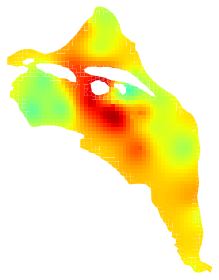

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, None, 'Yref', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_{ref}.pdf', dpi=300)

In [8]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [9]:
if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file ../data/yobs/yobs_100_1x.npy
iYobs.shape=(10, 100)
[[   4   14   31   34   52   53   54   82   89  122  141  142  148  152
   187  191  192  218  231  254  260  278  302  315  322  326  333  342
   347  361  362  364  376  408  420  427  431  434  438  446  458  465
   481  483  487  529  535  536  554  558  587  597  620  651  667  674
   737  758  761  838  847  853  857  863  884  897  900  930  942  961
  1001 1003 1030 1031 1054 1061 1069 1081 1095 1114 1122 1126 1131 1157
  1164 1175 1178 1187 1239 1270 1280 1285 1305 1338 1347 1352 1402 1438
  1444 1465]
 [  22   33   56   60   71   92  104  117  118  138  146  181  183  213
   216  227  246  248  276  302  306  311  329  333  336  352  378  388
   396  406  410  418  436  454  495  496  499  509  533  537  542  543
   545  547  548  600  611  615  641  643  648  668  673  678  681  692
   695  701  719  760  783  786  787  800  802  806  840  841  872  885
   906  918  933  954  961  965  968  998  999 

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_{Nens=}_ba_{conditional=}_Yref={ref}'
print(exp)

NY=100_Nu=323_NYlearn=100_NYxi=1000_Nens=100000_ba_conditional=True_ref='RF2_50_1x'


In [11]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
uens = np.zeros((2, num_trials, Nens, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
XiY = rs.randn(num_trials, Nens, NYxi)

In [12]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    if conditional:
        mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
        mYlearn.optimize(messages=True, ipython_notebook=False)
        print(f"{klearn.lengthscale.values[0]=}")
        print(f"{np.sqrt(klearn.variance.values[0])=}")

        mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t,:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
        Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    else:
        CYpred[t] = klearn.K(geom.cells.centroids.T)
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   6.399964e+01   4.480954e+04 
    00s03  0006   4.289318e+01   4.839826e+01 
    00s07  0013   4.063168e+01   2.353286e-06 
    00s08  0015   4.063168e+01   5.279878e-08 
Runtime:     00s08
Optimization status: Converged

klearn.lengthscale.values[0]=0.09259230123264314
np.sqrt(klearn.variance.values[0])=1.3428863243636697
GPR: [0.35363162] s


In [13]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYpred[t], NYxi)
    timings[t, 1] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 1]} s")

eigendecomposition: [1.77402167] s


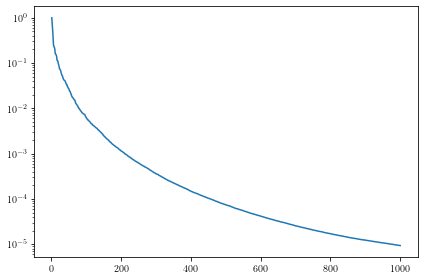

In [14]:
plt.plot(np.arange(1, NYxi + 1), LambdaY[0] / LambdaY[0, 0])
plt.yscale('log')
plt.tight_layout()
plt.savefig(figures_path + f'eigenspectrum_{exp}.pdf', dpi=300)

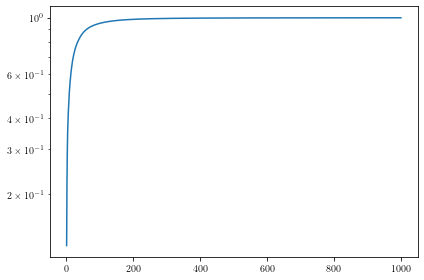

In [15]:
plt.plot(np.arange(1, NYxi + 1), np.cumsum(LambdaY[0])/np.sum(LambdaY[0]))
plt.yscale('log')
plt.tight_layout()
plt.savefig(figures_path + f'eigenspectrum_cum_{exp}.pdf', dpi=300)


In [16]:
for t in range(num_trials):
    # Compute GP model for u
    ts = perf_counter()
    uens[0, t] = ckliest.smc_ba(Ypred[t], PsiY[t], XiY[t], Nens, copy.deepcopy(prob))
    timings[t, 2] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 2]} s")

Monte Carlo: [492.29956752] s


In [17]:
""" NYxi_700 = 700
for t in range(num_trials):
    # Compute GP model for u
    ts = perf_counter()
    uens[1, t] = ckliest.smc_ba(Ypred[t],
        PsiY[t, :, :NYxi_700], XiY[t, :, :NYxi_700], Nens, copy.deepcopy(prob))
    timings[t, 3] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 2]} s")
 """


' NYxi_700 = 700\nfor t in range(num_trials):\n    # Compute GP model for u\n    ts = perf_counter()\n    uens[1, t] = ckliest.smc_ba(Ypred[t],\n        PsiY[t, :, :NYxi_700], XiY[t, :, :NYxi_700], Nens, copy.deepcopy(prob))\n    timings[t, 3] = perf_counter() - ts\n\nprint(f"Monte Carlo: {timings[:, 2]} s")\n '

In [19]:
hdf5storage.savemat(data_path + f'XiY_PsiY_u_{exp}.mat', {'Ypred': Ypred, 'XiY': XiY, 'PsiY': PsiY, 'u': uens[0]}, format='7.3', store_python_metadata=True)

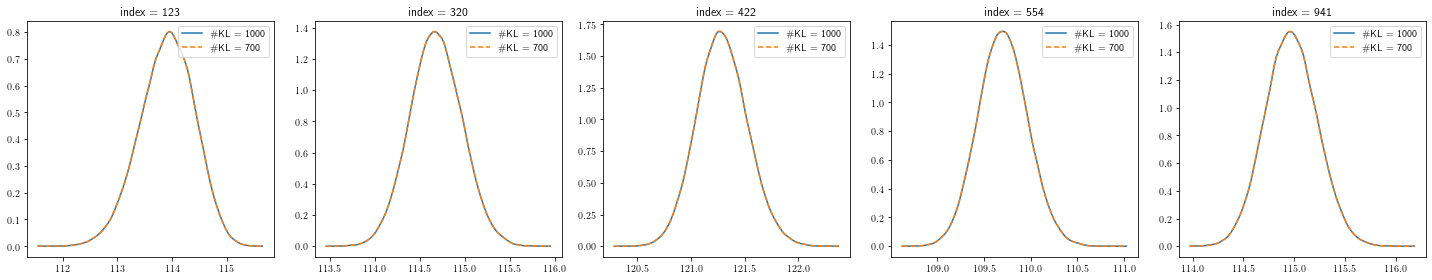

In [20]:
ind = np.array([122, 319, 421, 553, 940])
labels = ['#KL = 1000', '#KL = 700']
styles = ['-', '--']
ranges = np.array([[108, 118.5], [107, 129], [
                  110, 140], [105, 118], [107, 127]])
fig, ax = plt.subplots(1, ind.size, figsize=(20, 4))
for c, i in enumerate(ind):
    u = uens[0, 0, :, i]
    x = np.linspace(u.min(), u.max(), 100)
    ax[c].plot(x, sps.gaussian_kde(u)
               (x), linestyle='-', label='\#KL = 1000')
    ax[c].plot(x, sps.gaussian_kde(uens[1, 0, :, i])(x), linestyle='--', label='\#KL = 700')
    ax[c].set_title(f'index = {i+1}')
    ax[c].legend(loc='upper right')
fig.tight_layout()
fig.savefig(figures_path + f'u_pdf_{exp}.pdf', dpi=300)


In [19]:
print(uens[0, 0] - uens[1, 0])

[[ 6.79351100e-04  4.13768844e-04 -2.46114171e-04 ...  5.91015505e-05
  -1.22354238e-06 -3.44271527e-05]
 [ 4.29553847e-04  2.29556443e-04 -2.31269747e-04 ...  1.95706465e-04
  -1.01761858e-04  1.22528442e-04]
 [ 1.03185576e-04 -1.06311460e-04 -1.76199019e-05 ... -1.39511580e-04
   2.10097880e-05 -5.55510164e-05]
 ...
 [-5.17860751e-04 -3.67826608e-04  7.37414480e-05 ...  1.79350388e-04
  -1.98211599e-06 -1.62182023e-05]
 [ 5.68242674e-05  3.22491920e-05 -6.73689016e-05 ... -8.94435547e-05
   4.73158148e-05  3.72202813e-06]
 [-4.91112908e-04 -1.71702451e-04  3.01584419e-05 ...  1.41585640e-04
  -3.00782592e-04  1.31273880e-04]]
